In [1]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


Kaggle credentials set.
Kaggle credentials successfully validated.


In [2]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

dalubuzwezimase_labelled_path = kagglehub.dataset_download('dalubuzwezimase/labelled')
dalubuzwezimase_v2dataset_path = kagglehub.dataset_download('dalubuzwezimase/v2dataset')

print('Data source import complete.')


100%|██████████| 20.6M/20.6M [00:00<00:00, 78.1MB/s]

Extracting files...


100%|██████████| 22.7M/22.7M [00:00<00:00, 50.6MB/s]

Extracting files...


Data source import complete.


In [3]:
from huggingface_hub import notebook_login

notebook_login()

In [20]:
%pip install git-lfs

In [21]:
%pip install -U pip
%pip install transformers datasets torch pandas numpy seaborn matplotlib nltk

In [22]:
%pip install nltk

In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from nltk import word_tokenize
import string
import re
import nltk
import warnings
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import torch
from transformers import TrainingArguments, Trainer,AutoModelForSequenceClassification, GenerationConfig, AutoTokenizer

In [24]:
%pip install nltk['punkt']

In [25]:
%pip install transformers[torch]

In [26]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [27]:
# %loading datasets from data dir
df = pd.read_csv(dalubuzwezimase_v2dataset_path + "/train_v0.2.csv")

# Total Records
print("Total Records: ", df.shape[0])

# % preview data from top
df.head()

Total Records:  22207


,text,label
0,"Bodi ya Utalii Tanzania (TTB) imesema, itafan...",uchumi
1,"PENDO FUNDISHA-MBEYA RAIS Dk. John Magufuri, ...",kitaifa
2,Mwandishi Wetu -Singida BENKI ya NMB imetoa ms...,uchumi
3,"TIMU ya taifa ya Tanzania, Serengeti Boys jan...",michezo
4,Na AGATHA CHARLES – DAR ES SALAAM ALIYEKUWA K...,kitaifa


In [28]:
df['News Category'] = df['label']
# Create the 'label' column, where 'Kataifa' is mapped to 1, and the rest to 0
df['label'] = np.where(df['label'] == 'kitaifa', 1, 0)

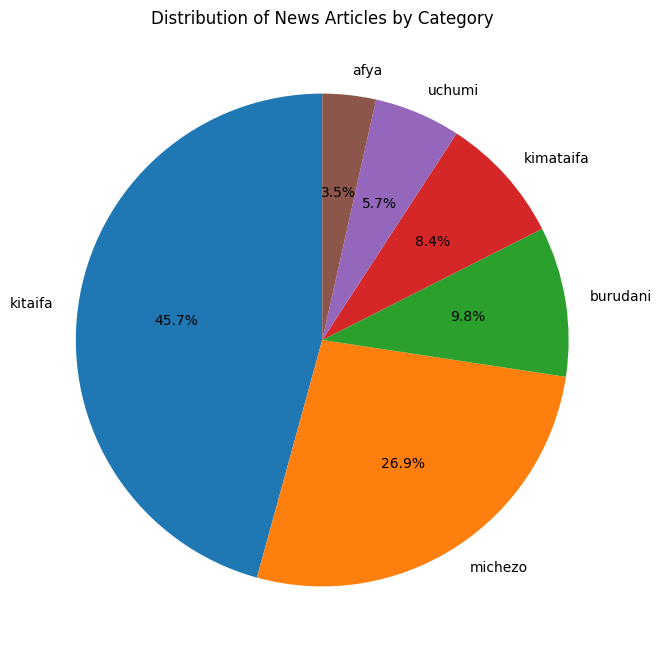

In [29]:
# @title Distribution of News Articles by Category



# Assuming your data is in a pandas DataFrame called 'df'
category_counts = df['News Category'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=90)
_ = plt.title('Distribution of News Articles by Category')

In [30]:
df2 = pd.read_csv(dalubuzwezimase_labelled_path + "/train_data1.csv")

# Total Records
print("Total Records: ", df2.shape[0])

# % preview data from top
df2.head()

Total Records:  10100


,text,label
0,"\n\n \n\tMjumbe wa Serikali ya kijiji, Salum I...",1
1,"MKUU wa Mkoa wa Morogoro, Dk Kebwe Stephen am...",1
2,"KATIKA kukuza sekta ya utalii nchini, Shirika...",1
3,RAIS John Magufuli amewataka wananchi kuchagu...,1
4,"SHOMARI BINDA -MUSOMA MWALIMU mstaafu, ambaye ...",1


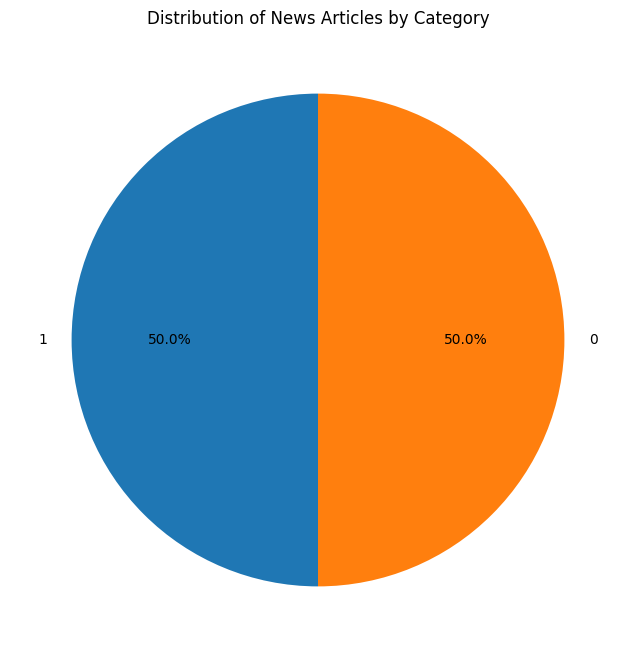

In [31]:
# @title Distribution of News Articles by Category
# Assuming your data is in a pandas DataFrame called 'df'
category_counts = df2['label'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=90)
_ = plt.title('Distribution of News Articles by Category')

In [32]:
# %function to clean text
def clean_text(sentence):
    '''
        function to clean content column, make it ready for transformation and modeling
    '''
    sentence = sentence.lower()                #convert text to lower-case
    sentence = re.sub('â€˜','',sentence)    # remove the text â€˜ which appears to occur flequently
    sentence = re.sub('[‘’“”…,]', '', sentence) # remove punctuation
    sentence = re.sub('[()]', '', sentence)  #remove parentheses
    sentence = re.sub("[^a-zA-Z]"," ",sentence) #remove numbers and keep text/alphabet only
    sentence = word_tokenize(sentence)      # remove repeated characters (tanzaniaaaaaaaa to tanzania)

    return ' '.join(sentence)

In [33]:
#remove null data
df = df[df['text'].notnull()]
#Applying our clean_text function on contents
df['text'] = df['text'].apply(clean_text)
df = df[df['text'] != '']

In [34]:
df.head()

,text,label,News Category
0,bodi ya utalii tanzania ttb imesema itafanya m...,0,uchumi
1,pendo fundisha mbeya rais dk john magufuri ame...,1,kitaifa
2,mwandishi wetu singida benki ya nmb imetoa msa...,0,uchumi
3,timu ya taifa ya tanzania serengeti boys jana ...,0,michezo
4,na agatha charles dar es salaam aliyekuwa kati...,1,kitaifa


In [35]:
from huggingface_hub import notebook_login,get_full_repo_name
model_name='Afriberta-Swahili-mlm_model'
repo_name = get_full_repo_name(model_name)
#model.push_to_hub(repo_name)
#tokenizer.push_to_hub(repo_name)

In [36]:
# Create torch dataset
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]).squeeze(0) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

In [37]:
tokenizer = AutoTokenizer.from_pretrained(repo_name)

tokenizer_config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/1.55M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/4.98M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

In [38]:
X = list(df["text"])
y = list(df["label"])
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2,stratify=y)
X_train_tokenized = tokenizer(X_train, padding=True, truncation=True, max_length=512)
X_val_tokenized = tokenizer(X_val, padding=True, truncation=True, max_length=512)

In [39]:
train_dataset = Dataset(X_train_tokenized, y_train)
val_dataset = Dataset(X_val_tokenized, y_val)

In [40]:
def model_init(repo_name=repo_name):
    model = AutoModelForSequenceClassification.from_pretrained(repo_name,from_tf=True)

    # Create and set generation configuration
    generation_config = GenerationConfig(max_length=512)
    model.generation_config = generation_config

    # Remove max_length from model.config if it exists
    if hasattr(model.config, 'max_length'):
        delattr(model.config, 'max_length')

    return model

In [41]:
def compute_metrics(p):
    print(type(p))
    pred, labels = p
    # The predictions are logits for each sample in the batch.
    # We need to select the index with the highest logit for each sample
    # to get the predicted class.
    pred = np.argmax(pred, axis=1)

    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred)
    precision = precision_score(y_true=labels, y_pred=pred)
    f1 = f1_score(y_true=labels, y_pred=pred)

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

In [42]:
args = TrainingArguments(
    f"Swahili-Classifier-cola",
    eval_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    metric_for_best_model='eval_f1',
    load_best_model_at_end=True,
    push_to_hub=True,
)

In [43]:
repo_name

'Mahloromela/Afriberta-Swahili-mlm_model'

In [44]:
trainer = Trainer(
    model=AutoModelForSequenceClassification.from_pretrained(repo_name,from_tf=True),
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics

)

config.json:   0%|          | 0.00/720 [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/549M [00:00<?, ?B/s]

All TF 2.0 model weights were used when initializing XLMRobertaForSequenceClassification.

All the weights of XLMRobertaForSequenceClassification were initialized from the TF 2.0 model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use XLMRobertaForSequenceClassification for predictions without further training.


In [45]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.281400,0.262528,0.919162,0.893968,0.934023,0.913556
2,0.216300,0.252867,0.923891,0.907167,0.928607,0.917762
3,0.165400,0.310139,0.917136,0.880898,0.946824,0.912672
4,0.115500,0.360063,0.914209,0.911677,0.899557,0.905576
5,0.084400,0.415891,0.910381,0.900049,0.904481,0.902259


<class 'transformers.trainer_utils.EvalPrediction'>
<class 'transformers.trainer_utils.EvalPrediction'>
<class 'transformers.trainer_utils.EvalPrediction'>
<class 'transformers.trainer_utils.EvalPrediction'>
<class 'transformers.trainer_utils.EvalPrediction'>


TrainOutput(global_step=5555, training_loss=0.18174074406456453, metrics={'train_runtime': 3394.567, 'train_samples_per_second': 26.165, 'train_steps_per_second': 1.636, 'total_flos': 7897831152476160.0, 'train_loss': 0.18174074406456453, 'epoch': 5.0})

In [48]:
from huggingface_hub import notebook_login

notebook_login()

In [49]:

trainer.push_to_hub()

<class 'transformers.trainer_utils.EvalPrediction'>


events.out.tfevents.1729800817.684593c7b224.588.1:   0%|          | 0.00/1.50k [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

events.out.tfevents.1729797375.684593c7b224.588.0:   0%|          | 0.00/10.1k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Mahloromela/Swahili-Classifier-cola/commit/b409e83f54571a0f91d43cd105ed0475c1b37824', commit_message='End of training', commit_description='', oid='b409e83f54571a0f91d43cd105ed0475c1b37824', pr_url=None, pr_revision=None, pr_num=None)

In [50]:
trainer.evaluate()

<class 'transformers.trainer_utils.EvalPrediction'>


{'eval_loss': 0.2528671622276306,
 'eval_accuracy': 0.9238910155370412,
 'eval_precision': 0.9071669071669072,
 'eval_recall': 0.9286065977351059,
 'eval_f1': 0.9177615571776155,
 'eval_runtime': 46.4462,
 'eval_samples_per_second': 95.616,
 'eval_steps_per_second': 5.985,
 'epoch': 5.0}

## Baseline Model

In [51]:
model_name='castorini/afriberta_small'

In [52]:
args = TrainingArguments(
    f"Baseline-Swahili-Classifier-cola",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    metric_for_best_model='eval_f1',
    load_best_model_at_end=True,
    push_to_hub=True,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [53]:
trainer1 = Trainer(

    model=AutoModelForSequenceClassification.from_pretrained('castorini/afriberta_small'),
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

config.json:   0%|          | 0.00/730 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/333M [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at castorini/afriberta_small and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [54]:
trainer1.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.271100,0.223678,0.924567,0.907692,0.929591,0.918511
2,0.200100,0.230355,0.932222,0.906485,0.949778,0.927627
3,0.153900,0.242378,0.934925,0.905493,0.957656,0.930845
4,0.097900,0.275113,0.931097,0.921760,0.928114,0.924926
5,0.076100,0.330151,0.930421,0.914740,0.935007,0.924763


<class 'transformers.trainer_utils.EvalPrediction'>


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 512}


<class 'transformers.trainer_utils.EvalPrediction'>


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 512}


<class 'transformers.trainer_utils.EvalPrediction'>


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 512}


<class 'transformers.trainer_utils.EvalPrediction'>


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 512}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 512}


<class 'transformers.trainer_utils.EvalPrediction'>


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 512}


TrainOutput(global_step=5555, training_loss=0.16734698353105573, metrics={'train_runtime': 3257.2176, 'train_samples_per_second': 27.269, 'train_steps_per_second': 1.705, 'total_flos': 7897831152476160.0, 'train_loss': 0.16734698353105573, 'epoch': 5.0})

In [55]:

trainer1.push_to_hub()

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 512}


<class 'transformers.trainer_utils.EvalPrediction'>


events.out.tfevents.1729801340.684593c7b224.588.2:   0%|          | 0.00/10.1k [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

events.out.tfevents.1729804645.684593c7b224.588.3:   0%|          | 0.00/560 [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Mahloromela/Baseline-Swahili-Classifier-cola/commit/6989a414bdfb42246b23c8084fc7305118228cb8', commit_message='End of training', commit_description='', oid='6989a414bdfb42246b23c8084fc7305118228cb8', pr_url=None, pr_revision=None, pr_num=None)

In [56]:
trainer1.evaluate()

<class 'transformers.trainer_utils.EvalPrediction'>


{'eval_loss': 0.24237829446792603,
 'eval_accuracy': 0.9349245665390677,
 'eval_precision': 0.9054934823091247,
 'eval_recall': 0.9576563269325455,
 'eval_f1': 0.9308446996889208,
 'eval_runtime': 46.9506,
 'eval_samples_per_second': 94.589,
 'eval_steps_per_second': 5.921,
 'epoch': 5.0}